Code to replicate sequence-to-sequence architecture, with Bahdanau attention

In [2]:
# https://arxiv.org/pdf/1409.0473.pdf
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# https://blog.floydhub.com/attention-mechanism/
# https://github.com/divyeshrajpura4114/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb
# https://colab.research.google.com/drive/1uFJBO1pgsiFwCGIJwZlhUzaJ2srDbtw-#scrollTo=KN8G-3YY8ADm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import re
import spacy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
!python -m spacy download de_core_news_sm

     |████████████████████████████████| 14.9MB 1.2MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=637a5d2dcf3cc557a02f6e2152c57c2311c1569abc4b128206afae116a66da0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-rihkzoxw/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [7]:
# https://stackoverflow.com/questions/56927602/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab
# https://spacy.io/usage/models

!pip install de_core_news_sm

In [8]:
import de_core_news_sm
spacy_de = de_core_news_sm.load()

In [9]:
!pip install en_core_web_sm

In [10]:
import en_core_web_sm
spacy_en = en_core_web_sm.load()

In [11]:
url = re.compile('(<url>.*</url>)')

In [12]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(url.sub('@URL@', text))]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(url.sub('@URL@', text))]

In [13]:
from torchtext.data.utils import get_tokenizer

DE = data.Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>')
EN = data.Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>')

In [14]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/data/data/translation/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=('.de', '.en'), fields=(DE, EN))
print('Loaded data...')

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 4.58MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.30MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.39MB/s]


Loaded data...


In [16]:
print(train_data.fields)
print(len(train_data))
print(len(valid_data))
print(vars(train_data[0]))
print(vars(train_data[100]))
print(vars(valid_data[100]))

{'src': <torchtext.data.field.Field object at 0x7f2a0b075358>, 'trg': <torchtext.data.field.Field object at 0x7f2a0b075080>}
29000
1014
{'src': ['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.'], 'trg': ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['Männliches', 'Kleinkind', 'in', 'einem', 'roten', 'Hut', ',', 'das', 'sich', 'an', 'einem', 'Geländer', 'festhält', '.'], 'trg': ['Toddler', 'boy', 'in', 'a', 'red', 'hat', 'holding', 'on', 'to', 'some', 'railings', '.']}
{'src': ['Ein', 'älterer', ',', 'übergewichtiger', 'Mann', 'wendet', 'einen', 'Pfannkuchen', ',', 'während', 'er', 'Frühstück', 'macht', '.'], 'trg': ['An', 'older', ',', 'overweight', 'man', 'flips', 'a', 'pancake', 'while', 'making', 'breakfast', '.']}


In [17]:
# set source and target language
DE.build_vocab(train_data.src, min_freq=3)
EN.build_vocab(train_data.trg, min_freq=3)

In [18]:
train_iter, valid_iter = data.BucketIterator.splits((train_data, valid_data), batch_size=32, device=device)

print(DE.vocab.freqs.most_common(10))
print(len(DE.vocab))
print(EN.vocab.freqs.most_common(10))
print(len(EN.vocab))

[('.', 28821), ('Ein', 13904), ('einem', 13697), ('in', 11830), (',', 8938), ('und', 8925), ('mit', 8838), ('auf', 8686), ('Mann', 7805), ('einer', 6750)]
5500
[('a', 31707), ('.', 27623), ('A', 17458), ('in', 14847), ('the', 9923), ('on', 8019), ('is', 7524), ('and', 7378), ('man', 7359), ('of', 6871)]
4727


In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, device):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)

        self.device = device
        self.to(self.device)
        
    def forward(self, input, hidden):
        # input is of shape [1, batch_size]
        # embedded is of shape [1, batch_size, embedding_size]

        input = input.to(self.device)

        embedded = self.embed(input)
        output, hidden = self.gru(embedded, hidden)

        # output shape is [1, batch_size, hidden_dim]
        # hidden shape is [num_layers, batch_size, hidden_dim]

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


In [20]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, n_dropout, device):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_dropout = n_dropout

        self.embed = nn.Embedding(vocab_size, self.embedding_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.n_dropout)

        self.align = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.V = nn.Parameter(torch.rand(hidden_size))

        self.appl_context = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.device = device
        self.to(self.device)

    def forward(self, input, hidden, enc_outputs):
        # input is of shape [batch_size]
        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]
        # hidden is of shape [1, batch_size, hiden_dim]

        batch_size = hidden.size(1)

        # Attention

        hidden_context = hidden.clone().detach().requires_grad_(True)
        hidden_context = hidden_context.repeat(enc_outputs.size(0), 1, 1)

        # Hidden is expanded to sequence_len
        # Hidden is now of shape [sequence_len, batch_size, hidden_dim]

        attn_in = torch.cat((enc_outputs, hidden_context), dim=-1)
        # combined enc_outputs and hidden:  [sequence_len, batch_size, hidden_dim * 2]

        aligned = self.align(attn_in)
        aligned = torch.tanh(aligned)
        
        aligned = aligned.permute(1, 2, 0)
        #aligned = [batch size, hidden_dim, sequence_len]
        
        #v = [hidden_dim]
        v = self.V.repeat(batch_size, 1).unsqueeze(1)
        #v = [batch size, 1, dec hid dim]

        attention = torch.bmm(v, aligned).squeeze(1)
        #attention = [batch size, src len]

        alphas = F.softmax(attention, dim=1)
        #alphas = [batch_size, sequence_len]

        alphas = alphas.unsqueeze(1)
        #alphas =  [batch_size, 1, sequence_len]

        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]
        enc_outputs = enc_outputs.permute(1, 0, 2)
        #enc_outputs = [batch_size, sequence_len, hidden_dim]

        context = torch.bmm(alphas, enc_outputs)
        #weighted = [batch_size, 1, hidden_dim]
        
        context = context.permute(1, 0, 2)
        #context: [1, batch_size, hidden_dim]

        # Decoder

        batch_size = hidden.size(1)
        
        input = input.unsqueeze(0)
        # now, input shape is [1, batch_size]

        input = input.to(self.device)

        embedded = self.embed(input)
        embedded = self.dropout(embedded)
        # embedded is of shape [1, batch_size, embedding_dim]

        output = torch.cat((embedded, context), dim=-1)
        #output:  [1, batch_size, hidden_dim + embedding_dim]

        output = self.appl_context(output)
        output = F.relu(output)

        output, hidden = self.gru(output, hidden)
        #output:  [1, batch_size, hidden_dim]

        output = self.out(output.squeeze(0))
        #output:  [1, batch_size, vocab_size]

        output = self.logsoftmax(output)

        return output, hidden, alphas


In [ ]:
#print(enc)
#print(dec)

In [21]:
vocab_size_src = len(DE.vocab)
vocab_size_trg = len(EN.vocab)

embedding_size = 300
hidden_size = 128
n_dropout = 0.1

enc = EncoderRNN(vocab_size_src, embedding_size, hidden_size, device)
dec = AttentionDecoderRNN(vocab_size_trg, embedding_size, hidden_size, n_dropout, device)

enc_optim = optim.Adam(enc.parameters())
dec_optim = optim.Adam(dec.parameters())
    
pad_idx = EN.vocab.stoi['<pad>']
print('Pad index: ', pad_idx)
criterion = nn.NLLLoss(ignore_index=pad_idx)

epochs = 20
clip = 10

epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0

    for batch in train_iter:
        hidden = enc.init_hidden(batch.src.size(1))

        max_len_enc = batch.src.size(0)

        enc_outputs, hidden = enc(batch.src, hidden)

        # store outputs
        max_len_dec = batch.trg.size(0)

        outputs = torch.zeros(max_len_dec, batch.trg.size(1), vocab_size_trg, device=device)
        input = batch.trg[0]
        
        for i in range(1, max_len_dec):
            output, hidden, _ = dec(input, hidden, enc_outputs)
            outputs[i] = output
            input = batch.trg[i]

        enc_optim.zero_grad()
        dec_optim.zero_grad()

        target = torch.tensor(batch.trg[1:], device=device)
        loss = criterion(outputs[1:].view(-1, outputs.shape[2]), target.view(-1))
        loss.backward()

        nn.utils.clip_grad_norm_(enc.parameters(), clip)
        nn.utils.clip_grad_norm_(dec.parameters(), clip)

        enc_optim.step()
        dec_optim.step()

        epoch_loss += loss.item()
        print('\rEpoch {} : Loss {:.3f}'.format(epoch, epoch_loss / len(batch)), end="")

    print('\rEpoch {} : Loss {:.3f}'.format(epoch, epoch_loss / len(train_iter)))

    epoch_losses.append(epoch_loss / len(train_iter))

Pad index:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 : Loss 4.074
Epoch 1 : Loss 3.147
Epoch 2 : Loss 2.705
Epoch 3 : Loss 2.403
Epoch 4 : Loss 2.180
Epoch 5 : Loss 2.008
Epoch 6 : Loss 1.868
Epoch 7 : Loss 1.749
Epoch 8 : Loss 1.646
Epoch 9 : Loss 1.558
Epoch 10 : Loss 1.483
Epoch 11 : Loss 1.413
Epoch 12 : Loss 1.353
Epoch 13 : Loss 1.298
Epoch 14 : Loss 1.246
Epoch 15 : Loss 1.200
Epoch 16 : Loss 1.157
Epoch 17 : Loss 1.120
Epoch 18 : Loss 1.086
Epoch 19 : Loss 1.052


Text(0.5, 1.0, 'Training loss')

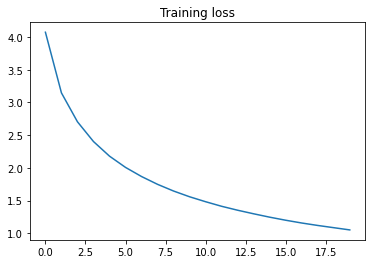

In [24]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.title("Training loss")

In [25]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [26]:
sos_idx = EN.vocab.stoi['<sos>']
eos_idx = EN.vocab.stoi['<eos>']

batch = next(iter(valid_iter))

for i in range(5):
    with torch.no_grad():
        encoder_input = batch.src[:, i].unsqueeze(1)
        hidden = enc.init_hidden(1)

        max_len_enc = batch.src.size(0)

        encoded = []
        for ip in encoder_input:
            encoded.append(DE.vocab.itos[ip.item()])

        enc_outputs, hidden = enc(encoder_input, hidden)

        max_len_dec = batch.trg.size(0)
        decoder_input = torch.tensor([sos_idx], device=device)
        decoder_attentions = torch.zeros(max_len_dec*2, max_len_enc)

        decoded = []
        decoded.append(EN.vocab.itos[sos_idx])
        true_output = batch.trg[:, i].unsqueeze(1)
        true = [EN.vocab.itos[w] for w in batch.trg[:, i].unsqueeze(1)]

        k = 0
        while True:
            output, hidden, alphas = dec(decoder_input, hidden, enc_outputs)
            topv, topi = output.topk(1)
            topi = topi.squeeze(1)
            decoder_input = topi.detach()
            
            decoder_attentions[k] = alphas
            k += 1
            
            decoded.append(EN.vocab.itos[decoder_input.item()])
            if decoder_input.item() == eos_idx:
                break

        print(encoded)
        print(decoded)
        print(true)
        print()

        #show_attention(encoded, decoded, decoder_attentions)

['<sos>', 'Ein', 'Kind', 'sitzt', 'auf', 'einer', '<unk>', '.', '<eos>']
['<sos>', 'A', 'child', 'sits', 'on', 'a', 'cement', 'wall', '.', '<eos>']
['<sos>', 'A', 'child', 'sitting', 'on', 'a', 'rock', 'formation', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Frauen', 'lächeln', 'bei', 'einer', 'Veranstaltung', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'smiling', 'at', 'a', 'restaurant', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'smiling', 'at', 'an', 'event', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Pudel', 'rennen', 'durch', 'den', 'Schnee', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'are', 'running', 'through', 'the', 'snow', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'are', 'running', 'through', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', '<unk>', '<unk>', 'tagsüber', 'ihre', '<unk>', '.', '<eos>', '<pad>']
['<sos>', '<unk>', '<unk>', "'s", '<unk>', "'s", 'rush', 'for', 'the', '<unk>', '.', '<eos>']
['<sos>', '<unk>